# **Online Shopper Behaviour - Comprehensive EDA and Predicting Revenue generation by session metrics of users**

In [1]:
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating requirement already satisfied
! pip install pyspark >& /dev/null

In [2]:
# Create Spark Session and Spark Context
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BDA-Project-V1').getOrCreate()
sc = spark.sparkContext

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Your Google Drive files are now accessible under '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Make sure that the file is unzipped directly into the root of the Google Drive to maintain the path integrity**

In [4]:
# Navigate to the file
data_file_path = "/content/drive/MyDrive/BDA Project - Group 2/online_shoppers_intention.csv"

# load the data in spark dataframe and view sample data

Shopper = spark.read.csv(data_file_path, header=True, inferSchema=True)
Shopper.show()

+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+-----------+----------+----------+-----+----------------+-------+------+-----------+-----------------+-------+-------+
|Administrative|Administrative_Duration|Informational|Informational_Duration|ProductRelated|ProductRelated_Duration|BounceRates|  ExitRates|PageValues|SpecialDay|Month|OperatingSystems|Browser|Region|TrafficType|      VisitorType|Weekend|Revenue|
+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+-----------+----------+----------+-----+----------------+-------+------+-----------+-----------------+-------+-------+
|             0|                    0.0|            0|                   0.0|             1|                    0.0|        0.2|        0.2|       0.0|       0.0|  Feb|               1|      1|     1|          1|Returning_Visitor|  false|  false|
|           

In [5]:
# see schema of the data columns

Shopper.printSchema()

root
 |-- Administrative: integer (nullable = true)
 |-- Administrative_Duration: double (nullable = true)
 |-- Informational: integer (nullable = true)
 |-- Informational_Duration: double (nullable = true)
 |-- ProductRelated: integer (nullable = true)
 |-- ProductRelated_Duration: double (nullable = true)
 |-- BounceRates: double (nullable = true)
 |-- ExitRates: double (nullable = true)
 |-- PageValues: double (nullable = true)
 |-- SpecialDay: double (nullable = true)
 |-- Month: string (nullable = true)
 |-- OperatingSystems: integer (nullable = true)
 |-- Browser: integer (nullable = true)
 |-- Region: integer (nullable = true)
 |-- TrafficType: integer (nullable = true)
 |-- VisitorType: string (nullable = true)
 |-- Weekend: boolean (nullable = true)
 |-- Revenue: boolean (nullable = true)



In [6]:
# get descriptive statistics of numeric columns

Shopper.describe().show()

+-------+------------------+-----------------------+------------------+----------------------+------------------+-----------------------+--------------------+--------------------+-----------------+-------------------+-----+------------------+------------------+------------------+-----------------+-----------------+
|summary|    Administrative|Administrative_Duration|     Informational|Informational_Duration|    ProductRelated|ProductRelated_Duration|         BounceRates|           ExitRates|       PageValues|         SpecialDay|Month|  OperatingSystems|           Browser|            Region|      TrafficType|      VisitorType|
+-------+------------------+-----------------------+------------------+----------------------+------------------+-----------------------+--------------------+--------------------+-----------------+-------------------+-----+------------------+------------------+------------------+-----------------+-----------------+
|  count|             12330|                  123

In [7]:
# check for null values

for c in Shopper.columns:
  print(c,": ", Shopper.filter(Shopper[c].isNull()).count())

Administrative :  0
Administrative_Duration :  0
Informational :  0
Informational_Duration :  0
ProductRelated :  0
ProductRelated_Duration :  0
BounceRates :  0
ExitRates :  0
PageValues :  0
SpecialDay :  0
Month :  0
OperatingSystems :  0
Browser :  0
Region :  0
TrafficType :  0
VisitorType :  0
Weekend :  0
Revenue :  0


In [8]:
# create view for spark sql query

Shopper.createOrReplaceTempView('shopper_d')


In [9]:
# Looking at data distribution by category columns
columns_to_count = ["OperatingSystems","Browser","Region","TrafficType","VisitorType","Weekend","Revenue"]

# Calculate category counts for each column
for column in columns_to_count:
    column_counts = Shopper.groupBy(column).count().orderBy("count", ascending=False)
    print(f"Category counts for '{column}':")
    column_counts.show()

Category counts for 'OperatingSystems':
+----------------+-----+
|OperatingSystems|count|
+----------------+-----+
|               2| 6601|
|               1| 2585|
|               3| 2555|
|               4|  478|
|               8|   79|
|               6|   19|
|               7|    7|
|               5|    6|
+----------------+-----+

Category counts for 'Browser':
+-------+-----+
|Browser|count|
+-------+-----+
|      2| 7961|
|      1| 2462|
|      4|  736|
|      5|  467|
|      6|  174|
|     10|  163|
|      8|  135|
|      3|  105|
|     13|   61|
|      7|   49|
|     12|   10|
|     11|    6|
|      9|    1|
+-------+-----+

Category counts for 'Region':
+------+-----+
|Region|count|
+------+-----+
|     1| 4780|
|     3| 2403|
|     4| 1182|
|     2| 1136|
|     6|  805|
|     7|  761|
|     9|  511|
|     8|  434|
|     5|  318|
+------+-----+

Category counts for 'TrafficType':
+-----------+-----+
|TrafficType|count|
+-----------+-----+
|          2| 3913|
|          1| 

# Exploratory Data Analysis

## - Looking at correlation

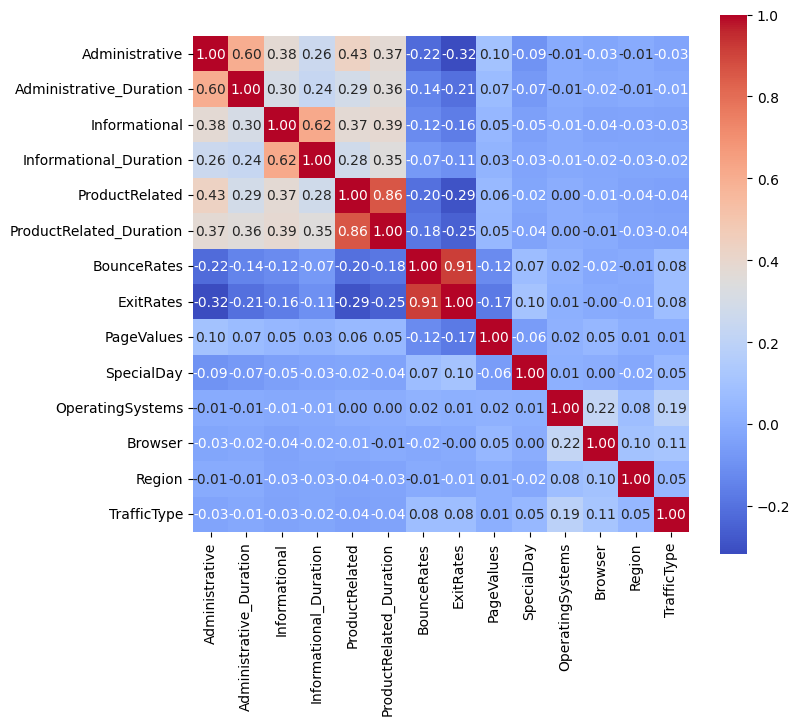

In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

# collect a list of numeric columns for correlation

columns = ["Administrative","Administrative_Duration","Informational","Informational_Duration"\
          ,"ProductRelated","ProductRelated_Duration","BounceRates","ExitRates","PageValues","SpecialDay"\
           ,"OperatingSystems","Browser","Region","TrafficType"]

# Combine the columns into a single vector column
assembler = VectorAssembler(inputCols=columns, outputCol="features")
df = assembler.transform(Shopper)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df, "features")

# Extract the correlation matrix as a PySpark DataFrame
corr_matrix_df = correlation_matrix.collect()[0]["pearson(features)"].toArray()

# Show the correlation matrix
import pandas as pd

corr_matrix_pd = pd.DataFrame(corr_matrix_df, columns=columns, index=columns)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', fmt=".2f", square=True)

# Show the plot
plt.show()

## - Scatter plot Counce Rate vs Exit Rate

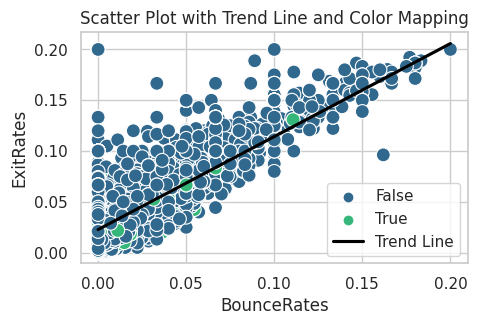

In [11]:
import pandas as pd
import numpy as np

#convert Shoppers to pandas dataframe for visualizations
df_scatter = Shopper.toPandas()

# scatter plot bounce rate vs exit rate
sns.set(style="whitegrid")  # Set the plot style
plt.figure(figsize=(5, 3))  # Set the figure size

# Create the scatter plot with color mapping
sns.scatterplot(data=df_scatter, x='BounceRates', y='ExitRates', hue='Revenue', palette='viridis', s=100)

# Add a trend line (regression line)
sns.regplot(data=df_scatter, x='BounceRates', y='ExitRates', scatter=False, color='black', label='Trend Line')

# Add a legend
plt.legend()

# Set plot labels and title
plt.xlabel('BounceRates')
plt.ylabel('ExitRates')
plt.title('Scatter Plot with Trend Line and Color Mapping')

# Show the plot
plt.show()

In [12]:
# counts by visitor type and revenue

visitor_revenue_count = spark.sql("select VisitorType,Revenue,count(VisitorType) from shopper_d group by VisitorType,Revenue order by VisitorType").show()

+-----------------+-------+------------------+
|      VisitorType|Revenue|count(VisitorType)|
+-----------------+-------+------------------+
|      New_Visitor|  false|              1272|
|      New_Visitor|   true|               422|
|            Other|  false|                69|
|            Other|   true|                16|
|Returning_Visitor|  false|              9081|
|Returning_Visitor|   true|              1470|
+-----------------+-------+------------------+



## - Visitor Type

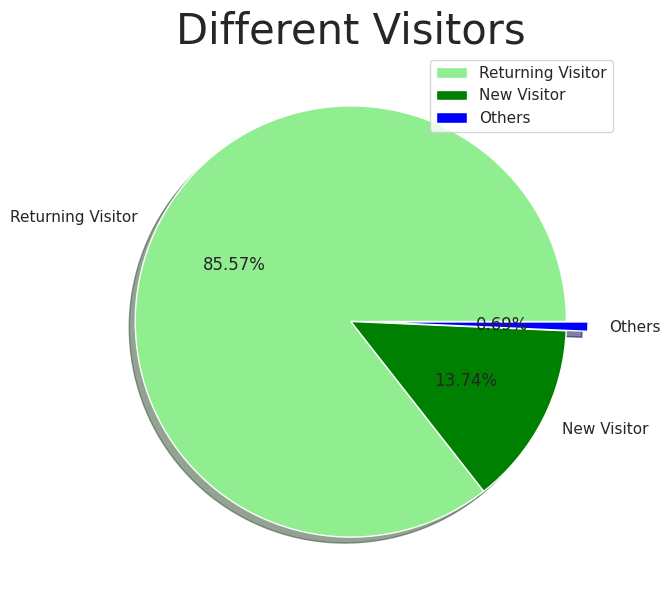

In [13]:
%matplotlib inline
import plotly as py
import plotly.graph_objs as go

df_scatter["VisitorType"].value_counts()

# plotting a pie chart for Visitors

plt.rcParams['figure.figsize'] = (18, 7)
size = [10551, 1694, 85]
colors = ['lightGreen', 'green', 'blue']
labels = "Returning Visitor", "New Visitor", "Others"
explode = [0, 0, 0.1]
plt.subplot(1, 2, 1)
plt.pie(size, colors = colors, labels = labels, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Different Visitors', fontsize = 30)
plt.axis('off')
plt.legend()
plt.show()

## - Visitor Type wrt Revenue

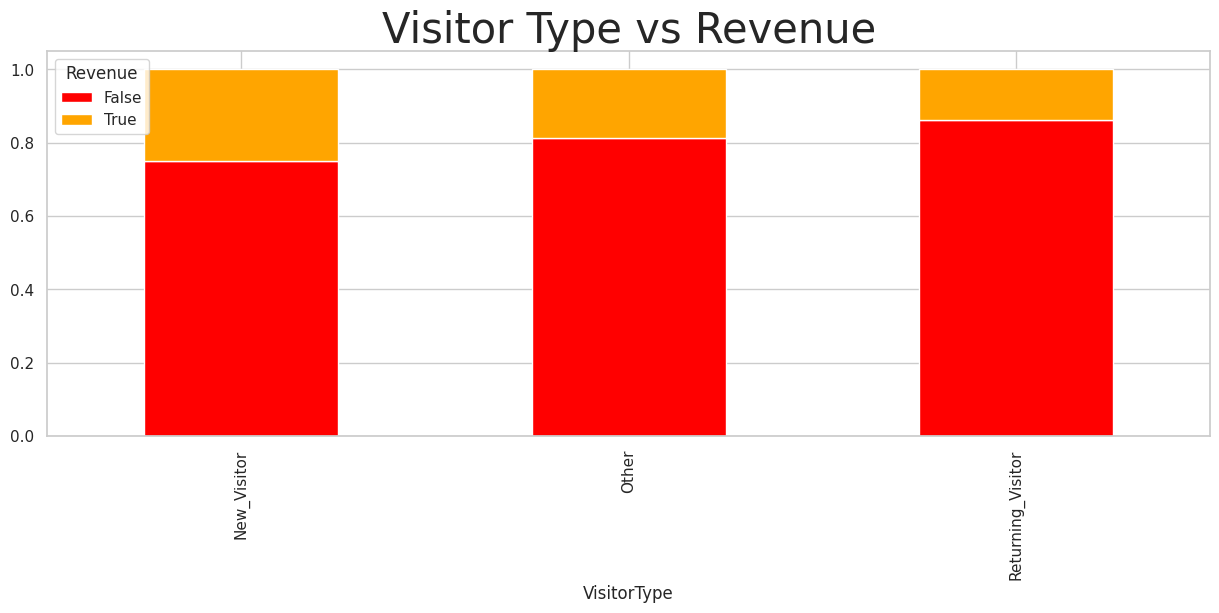

In [14]:
# bar plot for visitor type vs revenue
df = pd.crosstab(df_scatter['VisitorType'], df_scatter['Revenue'])
df.div(df.sum(1).astype(float), axis=0).plot(kind = 'bar', stacked = True, figsize =(15, 5), color = ['red', 'orange'])
plt.title('Visitor Type vs Revenue', fontsize = 30)
plt.show()


## - Revenue by Traffic Type

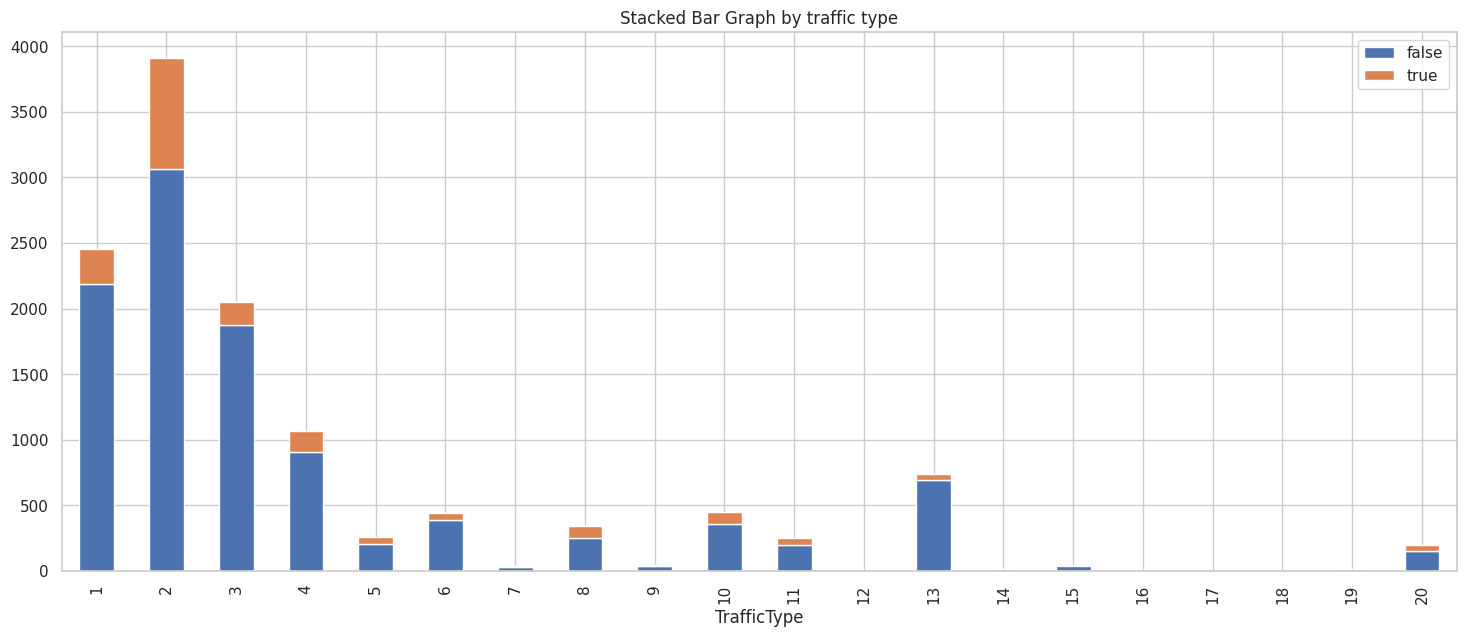

In [15]:
# Calculate the counts
counts = Shopper.groupBy("TrafficType", "Revenue").count().orderBy("TrafficType", "Revenue")

# Pivot the data for a stacked bar chart
pivoted = counts.groupBy("TrafficType").pivot("Revenue").sum("count").fillna(0).orderBy("TrafficType")

# Convert PySpark DataFrame to Pandas for plotting
pivoted_pd = pivoted.toPandas()

# Create a stacked bar chart
pivoted_pd.plot(x='TrafficType', kind='bar', stacked=True,
        title='Stacked Bar Graph by traffic type')
plt.show()

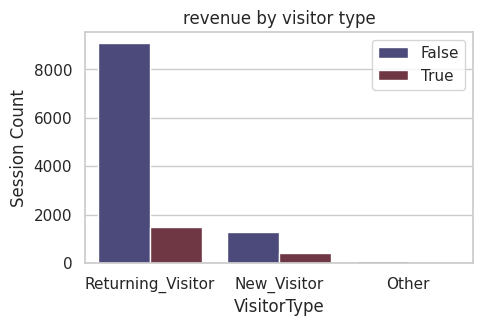

In [16]:
sns.set(style="whitegrid")  # Set the plot style
plt.figure(figsize=(5, 3))  # Set the figure size
#visitor_revenue_count = visitor_revenue_count.toPandas()

# Create the scatter plot with color mapping
sns.countplot(data=df_scatter, x='VisitorType', hue='Revenue', palette='icefire')

# Add a trend line (regression line)
#sns.regplot(data=df_scatter, x='BounceRates', y='VisitorType', scatter=False, color='black', label='Trend Line')

# Add a legend
plt.legend()

# Set plot labels and title
plt.xlabel('VisitorType')
plt.ylabel('Session Count')
plt.title('revenue by visitor type')

# Show the plot
plt.show()

## - Sessions by Month wrt Revenue


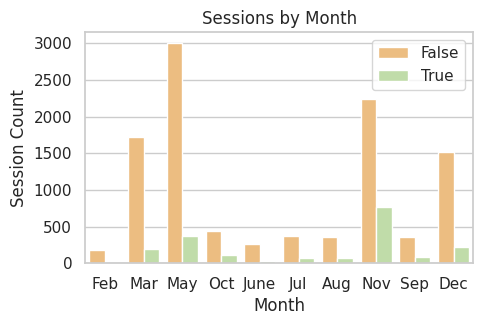

In [17]:
sns.set(style="whitegrid")  # Set the plot style
plt.figure(figsize=(5, 3))  # Set the figure size
#visitor_revenue_count = visitor_revenue_count.toPandas()

# Create the scatter plot with color mapping
sns.countplot(data=df_scatter, x='Month', hue='Revenue', palette='Spectral')

# Add a trend line (regression line)
#sns.regplot(data=df_scatter, x='BounceRates', y='VisitorType', scatter=False, color='black', label='Trend Line')

# Add a legend
plt.legend()

# Set plot labels and title
plt.xlabel('Month')
plt.ylabel('Session Count')
plt.title('Sessions by Month')

# Show the plot
plt.show()

## - Box Plots for Exit Rate by Month by Revenue

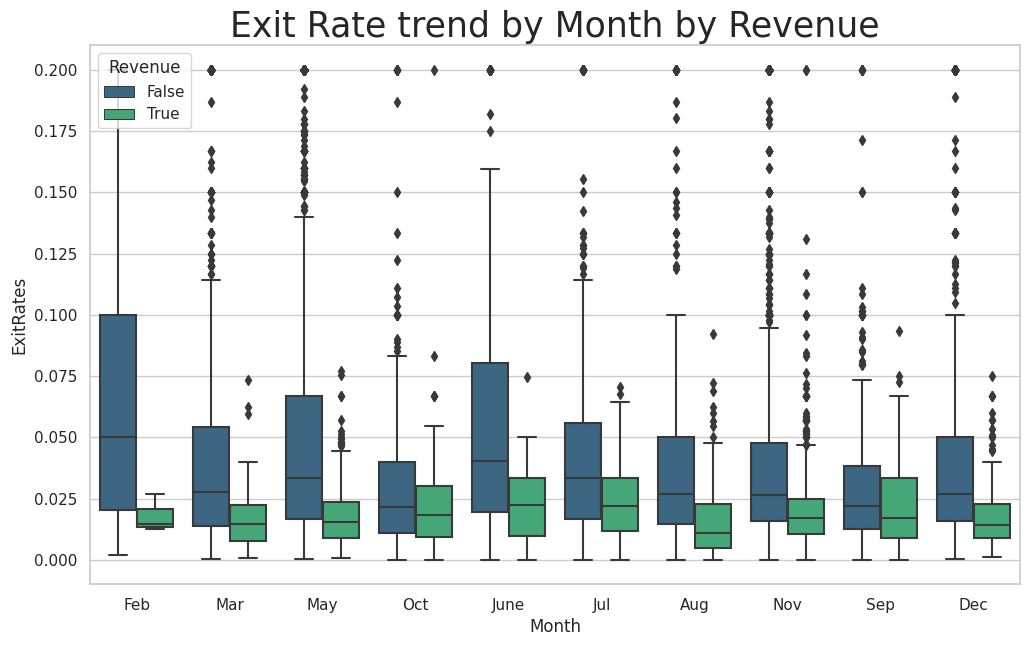

In [18]:
# boxplot for month vs exitrates w.r.t. revenue
plt.rcParams['figure.figsize'] = (12, 7)
sns.boxplot(x = df_scatter['Month'], y = df_scatter['ExitRates'], hue = df_scatter['Revenue'], palette = 'viridis')
plt.title('Exit Rate trend by Month by Revenue', fontsize = 25)
plt.show()

# **Feature Engineering**

In [19]:
# change boolean columns to integers
from pyspark.sql.functions import col

Shopper = Shopper.withColumn("Revenue", col("Revenue").cast("integer"))
Shopper = Shopper.withColumn("Weekend", col("Weekend").cast("integer"))

In [20]:
# Using string indexing and standard scaling for feature engineering process

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# List of categorical columns that need to be indexed and encoded
stringCategoricalColumns = ['Month', 'VisitorType']
stages = []  # stages in our Pipeline

# StringIndexer for string categorical columns
for categoricalCol in stringCategoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')
    stages += [stringIndexer]

# Assemble all the features with VectorAssembler
numericCols = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
               'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues','SpecialDay',
               'OperatingSystems', 'Browser', 'Region', 'TrafficType','Weekend']

assemblerInputs = [c + "Index" for c in stringCategoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Scale features using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
stages += [scaler]

# Create a Pipeline with all the stages
pipeline = Pipeline(stages=stages)

# Fit the pipeline to the data
pipelineModel = pipeline.fit(Shopper)

# Transform the data using the pipeline
Shopper_transformed = pipelineModel.transform(Shopper)

# Select the output column 'scaledFeatures' and 'label' for further processing
Shopper_transformed = Shopper_transformed.select('scaledFeatures', 'Revenue')

# Display the transformed dataframe
Shopper_transformed.show(5)

# 'Shopper_transformed' has scaled features which can be used for Supervised and Unsupervised modeling.

+--------------------+-------+
|      scaledFeatures|Revenue|
+--------------------+-------+
|(17,[0,6,8,9,12,1...|      0|
|(17,[0,6,7,9,12,1...|      0|
|(17,[0,6,8,9,12,1...|      0|
|(17,[0,6,7,8,9,12...|      0|
|(17,[0,6,7,8,9,12...|      0|
+--------------------+-------+
only showing top 5 rows



In [21]:
# checking for class imbalance

from pyspark.sql.functions import count
x = Shopper_transformed.groupby('Revenue').agg(count('*')).alias("count")
x.show()

+-------+--------+
|Revenue|count(1)|
+-------+--------+
|      1|    1908|
|      0|   10422|
+-------+--------+



# **Principle Component Analysis**

## - Scree Plot and Cumulative Variance Plot

In [22]:
num_features = len(Shopper_transformed.select("scaledFeatures").first()[0])
num_features

17

In [23]:
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans

# Apply PCA
pca = PCA(k=num_features, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcaModel = pca.fit(Shopper_transformed)
pcaResult = pcaModel.transform(Shopper_transformed)

In [24]:
explained_variance = pcaModel.explainedVariance

# Printing the explained variance for each principal component
print(explained_variance)

[0.20068440956252936,0.1055734521421264,0.08572440910213505,0.0745627390098885,0.06348241746175172,0.05905173475712366,0.05783064885864551,0.056626744251429016,0.05459629680655758,0.050348351193618586,0.045611650449124526,0.04463209495701123,0.044179871553373884,0.02474373066285654,0.020650829295642405,0.00721764554106237,0.004482974395123542]


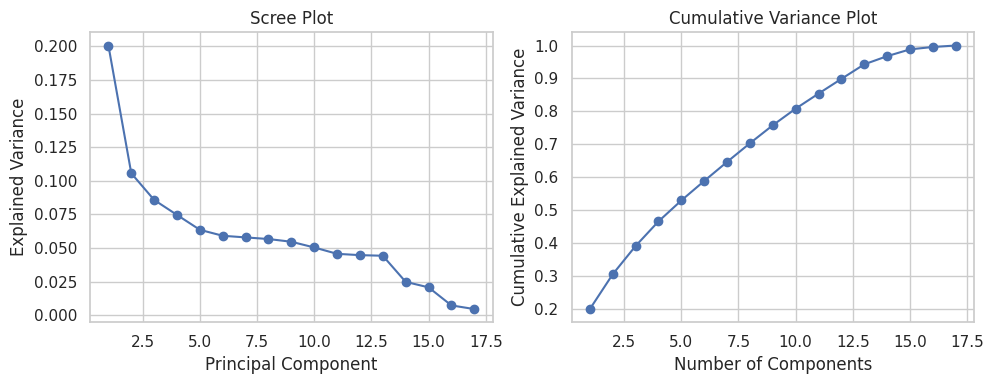

In [25]:
import matplotlib.pyplot as plt

# Creating a Scree Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_features + 1), explained_variance, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Scree Plot')

# Creating a Cumulative Variance Plot
cumulative_variance = explained_variance.cumsum()
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Plot')

plt.tight_layout()
plt.show()


In [26]:
# Apply PCA

num_components = 10 #(Optimal values based on the above graphs, covers 80% of the total variance)
pca = PCA(k=num_components, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcaModel = pca.fit(Shopper_transformed)
pcaResult = pcaModel.transform(Shopper_transformed)

# **K-Means**

## - Elbow Method for optimal K value

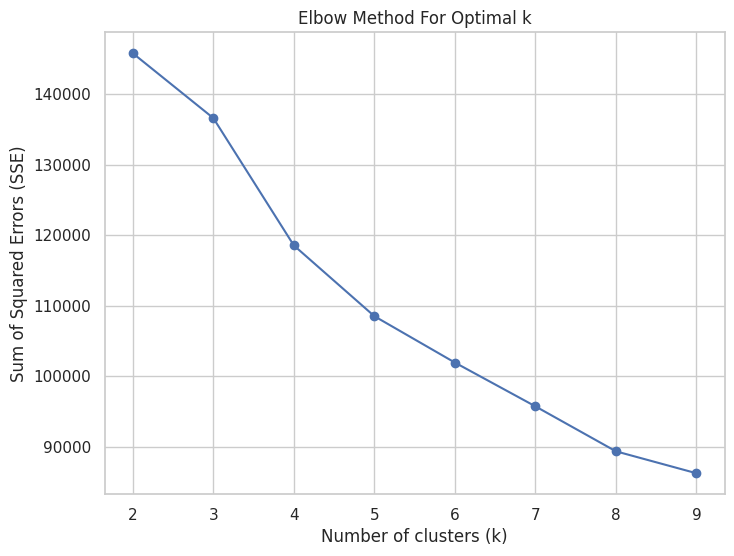

In [27]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np

feature_column = 'pcaFeatures'  # Use PCA features for clustering

# Range of k to try
k_range = range(2, 10)  # for example, trying k from 2 to 9

sse = []  # list to store the sum of squared errors for each k

for k in k_range:
    # Train a KMeans model
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol(feature_column)
    model = kmeans.fit(pcaResult)

    # Evaluate clustering by computing the SSE
    # We use trainingCost as a proxy for SSE
    sse.append(model.summary.trainingCost)

# Plotting the Elbow Plot
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.show()


## - Clustering with K-means

In [28]:
# Perform Clustering
num_clusters = 4  # Decide on the number of clusters
kmeans = KMeans().setK(num_clusters).setSeed(1).setFeaturesCol("pcaFeatures")
model = kmeans.fit(pcaResult)

# Make predictions
predictions = model.transform(pcaResult)

# Show results
predictions.select("pcaFeatures", "prediction").show(5)

+--------------------+----------+
|         pcaFeatures|prediction|
+--------------------+----------+
|[2.48724550951928...|         1|
|[0.69068220336083...|         3|
|[2.63252644743274...|         1|
|[1.30866678504169...|         1|
|[0.25184167810046...|         3|
+--------------------+----------+
only showing top 5 rows



## - Plotting clusters with PC1 and PC2

In [29]:
import pandas as pd
import plotly.express as px


pandas_df = predictions.select("pcaFeatures", "prediction", 'Revenue').toPandas()

# Extracting the first 10 PCA components
for i in range(10):
    pandas_df[f'pca{i+1}'] = pandas_df['pcaFeatures'].apply(lambda x: x[i])

# Separate plots for each 'Revenue' category
fig = px.scatter(pandas_df, x='pca1', y='pca2',
                 color='prediction',  # Cluster ID will determine the color
                 symbol='Revenue',    # Revenue will determine the shape
                 title='PCA Clustering Result (PCA1 vs PCA2)',
                 labels={'pca1': 'PCA 1', 'pca2': 'PCA 2'},
                 hover_data=['prediction'])

# Update the layout if necessary to ensure the legend is clear
fig.update_layout(legend=dict(
    title_font=dict(size=15),   # Adjust font size for readability
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

# Increase point size for better visibility
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')))

fig.show()


In [30]:
# First, group by 'prediction' and 'Revenue', then count the number of occurrences
cluster_revenue_count = pandas_df.groupby(['prediction', 'Revenue']).size().unstack(fill_value=0)

# Calculate the percentage of revenue=1 in each cluster
cluster_revenue_percentage = (cluster_revenue_count[1] / cluster_revenue_count.sum(axis=1)) * 100

# The result is a Series where the index is the cluster and the value is the percentage of revenue=1
print(cluster_revenue_percentage)


prediction
0    27.542198
1     0.573066
2    30.185185
3    12.869858
dtype: float64


In [31]:
#To find the best correlation of pca componenets with the prediction fo clustering
correlation = pandas_df.corr()
print(correlation['prediction'])

prediction    1.000000
Revenue      -0.118071
pca1          0.323799
pca2          0.304821
pca3         -0.131540
pca4         -0.177726
pca5         -0.024476
pca6         -0.410555
pca7         -0.132266
pca8         -0.008864
pca9          0.107601
pca10        -0.090507
Name: prediction, dtype: float64


<ipython-input-31-eb99eaf2d3c9>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



We can infer from the above output that PCA1 has the highest correlation followed by PCA2

## - Loading of PC1

In [32]:

import pandas as pd

loadings = pcaModel.pc.toArray()

# The shape of loadings is (10, 17) which means 10 PCA components and loadings for 17 features.

# Creating a list of PCA component names for the DataFrame columns
pca_component_names = ['PC{}'.format(i+1) for i in range(loadings.shape[0])]

# Transpose the loadings matrix to align with the DataFrame we want to create
# Each column in the DataFrame should correspond to a PCA component
loadings_transposed = loadings.T  # Transposing to a shape of (17, 10)

# Creating the DataFrame with the correct number of column names
loading_df = pd.DataFrame(loadings_transposed, columns=pca_component_names)

# Display the loadings for each principal component
print(loading_df['PC1'])



0   -0.008372
1    0.064845
2   -0.047123
3    0.619348
4   -0.295110
5   -0.190566
6    0.056185
7   -0.085154
8    0.102884
9   -0.030437
Name: PC1, dtype: float64


In [33]:
# Original categorical and numeric feature names
categorical_features = [col + "Index" for col in stringCategoricalColumns]
numeric_features = numericCols

# Combined list of feature names after transformation
transformed_feature_names = categorical_features + numeric_features

# Print the transformed feature names
print(transformed_feature_names)


['MonthIndex', 'VisitorTypeIndex', 'Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend']


In [34]:
#loadings for the first principal component
pc1_loadings = loading_df['PC1'].tolist()

# Map these loadings to the feature names
loadings_with_names = list(zip(transformed_feature_names, pc1_loadings))

loadings_with_names = sorted(loadings_with_names, key=lambda x : abs(x[1]), reverse=True)

# to print them
for feature, loading in loadings_with_names:
    print(f"{feature}: {loading}")


Administrative_Duration: 0.6193482054241606
Informational: -0.2951104017444401
Informational_Duration: -0.19056552910221167
BounceRates: 0.10288366445041967
ProductRelated_Duration: -0.0851535196123597
VisitorTypeIndex: 0.06484545138146292
ProductRelated: 0.05618513518533287
Administrative: -0.04712292960781847
ExitRates: -0.03043685401955603
MonthIndex: -0.00837160140519903


## - Loadings of PC2

In [35]:
# loadings for the second principal component
pc2_loadings = loading_df['PC2'].tolist()

# Map these loadings to the feature names
loadings_with_names = list(zip(transformed_feature_names, pc2_loadings))

loadings_with_names = sorted(loadings_with_names, key=lambda x : abs(x[1]), reverse=True)

# to print them
for feature, loading in loadings_with_names:
    print(f"{feature}: {loading}")

VisitorTypeIndex: 0.36325540854576427
Informational: 0.27046404487323356
Administrative: 0.25606405975918245
Administrative_Duration: 0.19530286764936863
ExitRates: 0.14137045874663698
Informational_Duration: 0.09517225651803526
ProductRelated: -0.06987075211990179
BounceRates: 0.05029757467474554
ProductRelated_Duration: -0.021071070471784706
MonthIndex: 0.013007902662783366


# **Supervised Modeling to predict Revenue from Session Metrics Data**

Creating 3 models Random Forest, Gradient Boosting Trees, and Logistic Regression to predict Revenue.

## - Create model Pipeline, fit data, and retrive AUC value for 3 models

In [36]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# train and test split
train, test = Shopper_transformed.randomSplit([0.8, 0.2], seed=42)

# Define the models
lr = LogisticRegression(labelCol="Revenue", featuresCol="scaledFeatures")
gbt = GBTClassifier(labelCol="Revenue", featuresCol="scaledFeatures")
rf = RandomForestClassifier(labelCol="Revenue", featuresCol="scaledFeatures")

# Set up the pipelines with only the model as a stage
lr_pipeline = Pipeline(stages=[lr])
gbt_pipeline = Pipeline(stages=[gbt])
rf_pipeline = Pipeline(stages=[rf])

# Assuming train and test sets are already defined
# Fit the models
lr_model = lr_pipeline.fit(train)
gbt_model = gbt_pipeline.fit(train)
rf_model = rf_pipeline.fit(train)

# Make predictions
lr_predictions = lr_model.transform(test)
gbt_predictions = gbt_model.transform(test)
rf_predictions = rf_model.transform(test)

# Evaluate the models
evaluator = BinaryClassificationEvaluator(labelCol="Revenue", rawPredictionCol="rawPrediction")

lr_auc = evaluator.evaluate(lr_predictions)
gbt_auc = evaluator.evaluate(gbt_predictions)
rf_auc = evaluator.evaluate(rf_predictions)

print("Logistic Regression AUC: ", lr_auc)
print("Gradient-Boosted Trees AUC: ", gbt_auc)
print("Random Forest AUC: ", rf_auc)

Logistic Regression AUC:  0.88533758455228
Gradient-Boosted Trees AUC:  0.9296845526567808
Random Forest AUC:  0.9021672889142336


## - ROC Curve Visualization


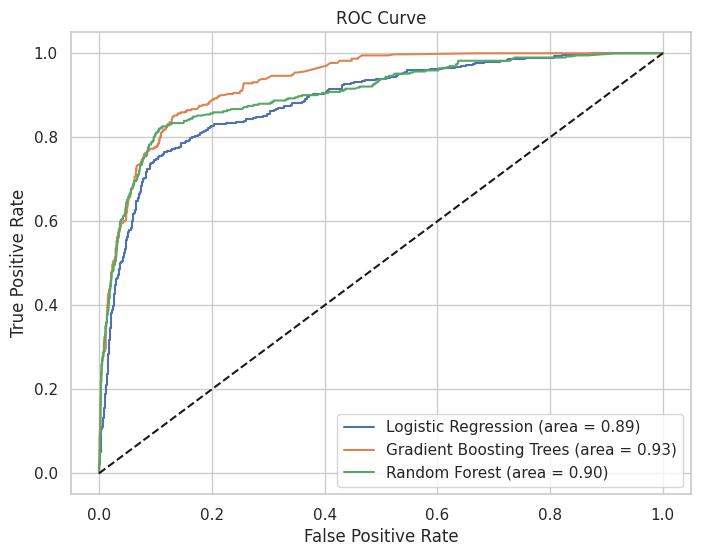

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

def extract_and_compute_roc_curve(predictions):
    # Extract the probability of the positive class
    results = predictions.select(['probability', 'Revenue']).rdd.map(lambda row: (float(row['probability'][1]), float(row['Revenue']))).collect()
    y_score, y_true = zip(*results)
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    return fpr, tpr

# Extract and compute ROC curve data
lr_fpr, lr_tpr = extract_and_compute_roc_curve(lr_predictions)
gbt_fpr, gbt_tpr = extract_and_compute_roc_curve(gbt_predictions)
rf_fpr, rf_tpr = extract_and_compute_roc_curve(rf_predictions)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (area = %0.2f)' % auc(lr_fpr, lr_tpr))
plt.plot(gbt_fpr, gbt_tpr, label='Gradient Boosting Trees (area = %0.2f)' % auc(gbt_fpr, gbt_tpr))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % auc(rf_fpr, rf_tpr))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## - Performance Metrics

In [38]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the evaluator for accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Revenue", predictionCol="prediction", metricName="accuracy")

# Calculate accuracy for each model
lr_accuracy = accuracy_evaluator.evaluate(lr_predictions)
gbt_accuracy = accuracy_evaluator.evaluate(gbt_predictions)
rf_accuracy = accuracy_evaluator.evaluate(rf_predictions)

# Print the accuracy for each model
print("Accuracy of Logistic Regression: ", lr_accuracy)
print("Accuracy of Gradient-Boosted Trees: ", gbt_accuracy)
print("Accuracy of Random Forest: ", rf_accuracy)

Accuracy of Logistic Regression:  0.8808933002481389
Accuracy of Gradient-Boosted Trees:  0.901571546732837
Accuracy of Random Forest:  0.8937138130686518


In [39]:
# RECALL

# Define the evaluator for recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Revenue", predictionCol="prediction", metricName="truePositiveRateByLabel", metricLabel=1)

# Calculate recall for each model
lr_recall = recall_evaluator.evaluate(lr_predictions)
gbt_recall = recall_evaluator.evaluate(gbt_predictions)
rf_recall = recall_evaluator.evaluate(rf_predictions)

# Print the recall for each model
print("Recall of Logistic Regression: ", lr_recall)
print("Recall of Gradient-Boosted Trees: ", gbt_recall)
print("Recall of Random Forest: ", rf_recall)

Recall of Logistic Regression:  0.37595907928388744
Recall of Gradient-Boosted Trees:  0.5959079283887468
Recall of Random Forest:  0.45268542199488493


In [40]:
# F1-SCORE

# Define the evaluator for F1 score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Revenue", predictionCol="prediction", metricName="f1")

# Calculate F1 score for each model
lr_f1_score = f1_evaluator.evaluate(lr_predictions)
gbt_f1_score = f1_evaluator.evaluate(gbt_predictions)
rf_f1_score = f1_evaluator.evaluate(rf_predictions)

# Print the F1 score for each model
print("F1 Score of Logistic Regression: ", lr_f1_score)
print("F1 Score of Gradient-Boosted Trees: ", gbt_f1_score)
print("F1 Score of Random Forest: ", rf_f1_score)

F1 Score of Logistic Regression:  0.8632281069677966
F1 Score of Gradient-Boosted Trees:  0.8970478538899088
F1 Score of Random Forest:  0.8809915853100155


In [41]:
# PRECISION

# Define the evaluator for precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Revenue", predictionCol="prediction", metricName="precisionByLabel", metricLabel=1)

# Calculate precision for each model
lr_precision = precision_evaluator.evaluate(lr_predictions)
gbt_precision = precision_evaluator.evaluate(gbt_predictions)
rf_precision = precision_evaluator.evaluate(rf_predictions)

# Print the precision for each model
print("Precision of Logistic Regression: ", lr_precision)
print("Precision of Gradient-Boosted Trees: ", gbt_precision)
print("Precision of Random Forest: ", rf_precision)

Precision of Logistic Regression:  0.7696335078534031
Precision of Gradient-Boosted Trees:  0.744408945686901
Precision of Random Forest:  0.8045454545454546
